In [1]:
# Cell 1: imports
import pandas as pd
import numpy as np

# Scikit‑learn for Random Forest and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Optional: for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_STATE = 42

In [2]:
# Cell 2: define regions and years
regions = ["Latin America", "Asia", "United States", "Europe"]
years = [2021, 2022, 2023, 2024]

In [3]:
# Cell 3: synthetic dataset creation

# number of samples
n_samples = 400  # roughly regions * years * some variations

rng = np.random.default_rng(RANDOM_STATE)

# Generate random samples
data = pd.DataFrame({
    "region": rng.choice(regions, size=n_samples),
    "year": rng.choice(years, size=n_samples),
    # Demographic / market features (normalized or scaled)
    "median_income_k": rng.normal(loc=30, scale=10, size=n_samples).clip(5, 100),  # in thousands
    "pop_age_18_34_pct": rng.normal(loc=30, scale=10, size=n_samples).clip(10, 60),  # percent
    "urbanization_pct": rng.normal(loc=70, scale=15, size=n_samples).clip(30, 100),  # percent
    # Marketing or distribution effort proxy
    "marketing_spend_m": rng.normal(loc=5, scale=3, size=n_samples).clip(0, 20),  # in millions
})

# Synthetic sales: base + region/year effects + feature contributions + noise
region_effect = {
    "United States": 50,
    "Europe": 40,
    "Asia": 30,
    "Latin America": 20
}
year_effect = {2021: 0, 2022: 5, 2023: 10, 2024: 15}

# Compute sales in millions units or revenue units
data["sales_m"] = (
    data["median_income_k"] * 0.2
    + data["pop_age_18_34_pct"] * 0.3
    + data["urbanization_pct"] * 0.1
    + data["marketing_spend_m"] * 2.0
    + data["region"].map(region_effect)
    + data["year"].map(year_effect)
    + rng.normal(0, 5, size=n_samples)  # noise
).clip(5, None)  # ensure positive

# Synthetic profit margin percent: base + some feature effects + noise
data["profit_margin_pct"] = (
    10
    + data["marketing_spend_m"] * -0.2  # assume more spend can slightly compress margin
    + (data["median_income_k"] / 100) * 2
    + rng.normal(0, 1, size=n_samples)
).clip(1, 25)

data.head()

,region,year,median_income_k,pop_age_18_34_pct,urbanization_pct,marketing_spend_m,sales_m,profit_margin_pct
0,Latin America,2024,34.396366,30.442124,65.257034,0.000000,58.529520,9.079121
1,Europe,2024,35.241878,27.970860,75.480456,7.828297,89.808189,9.807733
2,United States,2022,32.762742,19.175728,79.194481,2.045015,75.283336,11.369346
3,Asia,2024,15.872341,28.489481,67.885182,3.633416,63.975446,9.545768
4,Asia,2022,6.898966,22.539017,92.976683,0.840673,56.074138,8.008999


       region         year  median_income_k  pop_age_18_34_pct  \
count     400   400.000000       400.000000         400.000000   
unique      4          NaN              NaN                NaN   
top      Asia          NaN              NaN                NaN   
freq      110          NaN              NaN                NaN   
mean      NaN  2022.560000        29.501195          29.855337   
std       NaN     1.137821        10.126238           9.456255   
min       NaN  2021.000000         5.000000          10.000000   
25%       NaN  2022.000000        22.197841          23.778224   
50%       NaN  2023.000000        29.871343          30.049065   
75%       NaN  2024.000000        36.206496          35.458414   
max       NaN  2024.000000        55.976737          60.000000   

        urbanization_pct  marketing_spend_m     sales_m  profit_margin_pct  
count         400.000000         400.000000  400.000000         400.000000  
unique               NaN                NaN         N

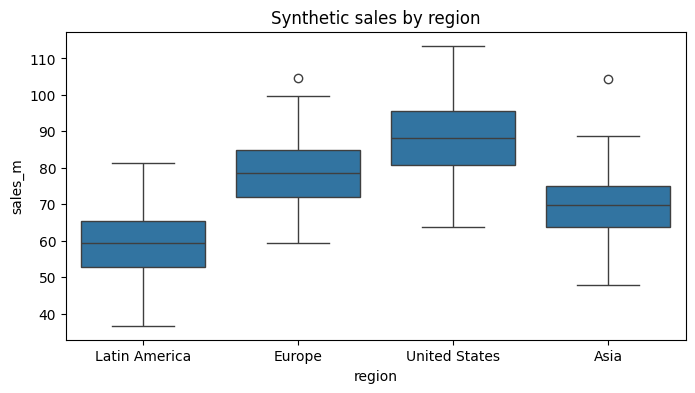

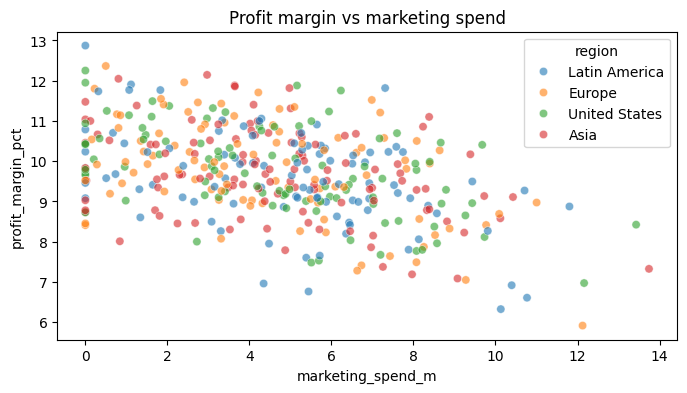

In [4]:
# Cell 4: quick overview
print(data.describe(include="all"))

# Optional: visualize sales distribution by region
plt.figure(figsize=(8, 4))
sns.boxplot(x="region", y="sales_m", data=data)
plt.title("Synthetic sales by region")
plt.show()

# Profit margin vs marketing spend
plt.figure(figsize=(8, 4))
sns.scatterplot(x="marketing_spend_m", y="profit_margin_pct", hue="region", data=data, alpha=0.6)
plt.title("Profit margin vs marketing spend")
plt.show()

In [5]:
# Cell 5a: features and target for sales
features = [
    "median_income_k",
    "pop_age_18_34_pct",
    "urbanization_pct",
    "marketing_spend_m",
    # encode region via dummy variables
]

X = pd.get_dummies(data[features + ["region", "year"]], drop_first=True)
y_sales = data["sales_m"]

# Train/test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y_sales, test_size=0.2, random_state=RANDOM_STATE
)

In [6]:
# Cell 5b: features and target for profit margin
y_profit = data["profit_margin_pct"]

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X, y_profit, test_size=0.2, random_state=RANDOM_STATE
)

In [7]:
# Cell 6a: Random Forest for sales
rf_sales = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1  # use all cores
)

rf_sales.fit(X_train_s, y_train_s)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [8]:
# Cell 6b: Random Forest for profit margin
rf_profit = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_profit.fit(X_train_p, y_train_p)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [9]:
# Cell 7a: evaluate sales model
y_pred_s = rf_sales.predict(X_test_s)

mse_s = mean_squared_error(y_test_s, y_pred_s)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test_s, y_pred_s)

print(f"Sales model RMSE: {rmse_s:.2f}")
print(f"Sales model R^2: {r2_s:.3f}")

Sales model RMSE: 5.55
Sales model R^2: 0.830


In [10]:
# Cell 7b: evaluate profit margin model
y_pred_p = rf_profit.predict(X_test_p)

mse_p = mean_squared_error(y_test_p, y_pred_p)
rmse_p = np.sqrt(mse_p)
r2_p = r2_score(y_test_p, y_pred_p)

print(f"Profit margin model RMSE: {rmse_p:.2f}")
print(f"Profit margin model R^2: {r2_p:.3f}")

Profit margin model RMSE: 1.11
Profit margin model R^2: 0.151


In [11]:
# Cell 8: feature importance for sales model
importances_s = pd.Series(rf_sales.feature_importances_, index=X_train_s.columns)
importances_s.sort_values(ascending=False).head(10)

region_United States    0.247072
region_Latin America    0.212540
marketing_spend_m       0.187599
year                    0.137954
region_Europe           0.076538
pop_age_18_34_pct       0.056809
median_income_k         0.046486
urbanization_pct        0.035002
dtype: float64

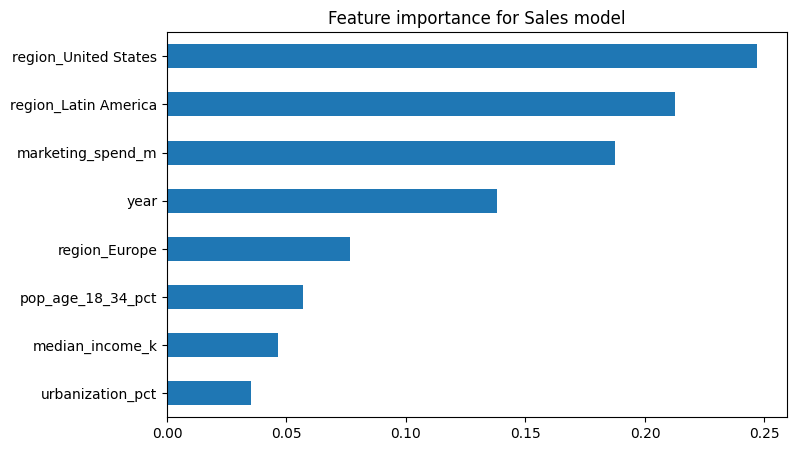

In [12]:
plt.figure(figsize=(8, 5))
importances_s.sort_values().plot(kind="barh")
plt.title("Feature importance for Sales model")
plt.show()

In [13]:
importances_p = pd.Series(rf_profit.feature_importances_, index=X_train_p.columns)
importances_p.sort_values(ascending=False).head(10)

marketing_spend_m       0.382164
median_income_k         0.226603
pop_age_18_34_pct       0.161421
urbanization_pct        0.129749
year                    0.053320
region_United States    0.017319
region_Europe           0.017206
region_Latin America    0.012218
dtype: float64

In [ ]:
# Cell 9: simple hyperparameter tuning via grid search (example for sales)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 3, 5],
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train_s, y_train_s)
print("Best params:", grid.best_params_)
print("Best CV R2:", grid.best_score_)